# Assignment 1 - Plotting Weather Patterns

For this assignment, I was instructed to:

1. Read the documentation and become familarized with the dataset. Then, write some Python code which returns a line graph of the record high and record low temperatures by day of the year over the period 2005-2014. The area between the record high and record low temperatures for each day should be shaded.
2. Overlay a scatter of the 2015 data for any points (highs and lows) for which the ten year record (2005-2014) record high or record low was broken in 2015.
3. Watch out for leap days (i.e. February 29th), it is reasonable to remove these points from the dataset for the purpose of this visualization.
4. Make the visual nice! Leverage principles from the first module in this course (Alberto Cairo's principles in Graphic Lies, Misleading Visuals). Consider issues such as legends, labels, and chart junk.


An NOAA dataset is available in the file `station.csv`.

Each row in the assignment datafile corresponds to a single observation.

The following variables are provided:

* **id** : station identification code
* **date** : date in YYYY-MM-DD format (e.g. 2012-01-24 = January 24, 2012)
* **element** : indicator of element type
    * TMAX : Maximum temperature (tenths of degrees C)
    * TMIN : Minimum temperature (tenths of degrees C)
* **value** : data value for element (tenths of degrees C)

In [1]:
%matplotlib notebook

import matplotlib.pyplot as plt
import mplleaflet
import pandas as pd

import numpy as np
import datetime as dt

The data I have been assigned is near **Ann Arbor, Michigan, United States**. 

In [2]:
df = pd.read_csv('station.csv')
df.head()

,ID,Date,Element,Data_Value
0,USW00094889,2014-11-12,TMAX,22
1,USC00208972,2009-04-29,TMIN,56
2,USC00200032,2008-05-26,TMAX,278
3,USC00205563,2005-11-11,TMAX,139
4,USC00200230,2014-02-27,TMAX,-106


In [3]:
# Convert data
df['Date'] = pd.to_datetime(df['Date'])
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['Year'] = df['Date'].dt.year

# Make dates in calendar order. This will make it easier to obtain 2015 data
df.sort_values(by=['Date'], inplace=True)

df.head()

,ID,Date,Element,Data_Value,Month,Day,Year
60995,USW00004848,2005-01-01,TMIN,0,1,1,2005
17153,USC00207320,2005-01-01,TMAX,150,1,1,2005
17155,USC00207320,2005-01-01,TMIN,-11,1,1,2005
10079,USW00014833,2005-01-01,TMIN,-44,1,1,2005
10073,USW00014833,2005-01-01,TMAX,33,1,1,2005


In [4]:
# Convert 1/10th Celsius into Celsius Degrees
df = df.rename(columns={'Data_Value': 'Celsius'})
df['Celsius'] = df['Celsius'].div(10)

# Remove leap days (February 29th)
## Use index to ensure leap day is removed
df.drop(df.loc[(df['Month']==2) & (df['Day']==29)].index, inplace=True)

# Create low and high temps dataframes: For decade, 2005-2014 and the single year, 2015. 
cutoff = '2015-01-01'
dec = df[df['Date'] < cutoff]
year = df[df['Date'] >= cutoff]


# For the decade (2005-2014):
## Find the lowest and highest tempertures by month
decLow = dec[dec['Element']=='TMIN'].groupby(['Month', 'Day']).agg({'Celsius': 'min'})
decHigh = dec[dec['Element']=='TMAX'].groupby(['Month', 'Day']).agg({'Celsius': 'max'})

# For the year 2015:
## Find the lowest and highest temperatures by month and day
yearLow = year[year['Element']=='TMIN'].groupby(['Month', 'Day']).agg({'Celsius': 'min'})
yearHigh = year[year['Element']=='TMAX'].groupby(['Month', 'Day']).agg({'Celsius': 'max'})

## Find the date of the lowest and highest temperatures for 2015. Use for x-axis
index_min = year[year['Element']=='TMIN'].groupby(['Date','Month', 'Day']).agg({'Celsius': 'min'})
index_min = index_min.reset_index().set_index(["Month", "Day"])
index_max = year[year['Element']=='TMAX'].groupby(['Date','Month', 'Day']).agg({'Celsius': 'max'})
index_max = index_max.reset_index().set_index(["Month", "Day"])

# Example of df created above:
index_min.head()

Date  Celsius
Month Day                    
1     1   2015-01-01    -13.3
      2   2015-01-02    -12.2
      3   2015-01-03     -6.7
      4   2015-01-04     -8.8
      5   2015-01-05    -15.5

<IPython.core.display.Javascript object>


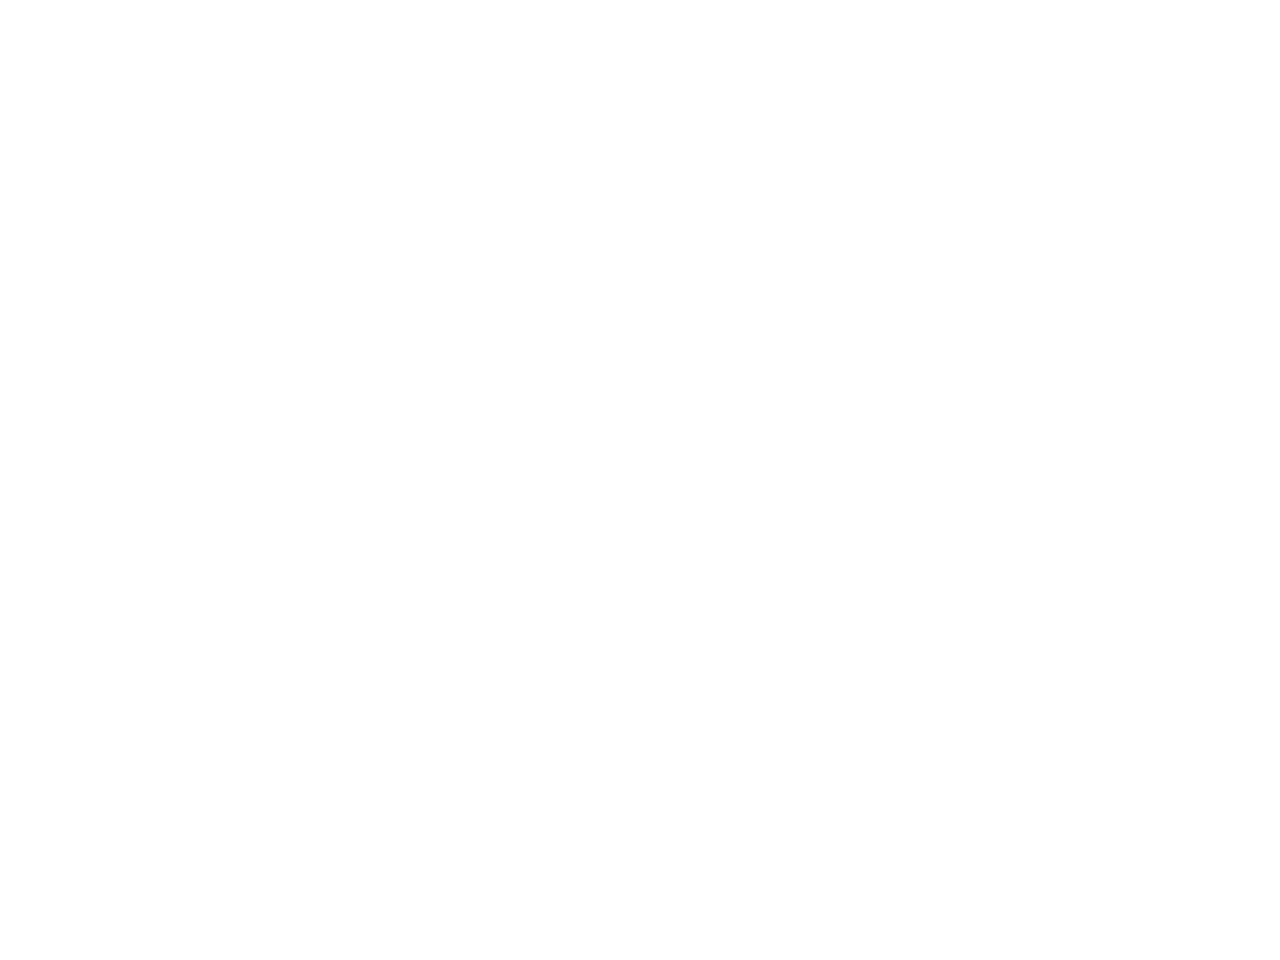

In [5]:
# Create a plot of the temperatures
plt.figure()
ax = plt.gca()
ax.set_xlabel('Months')
ax.set_ylabel('Temperature ($^{\circ}$C)')
ax.set_title('Record Temperatures in Ann Arbor, Michigan')
ax.set_facecolor('whitesmoke')

# Change x axis tick markers to reflect months
months = ['Jan.', 'Feb.', 'Mar.', 'Apr.', 'May', 'June', 'July', 'Aug.', 'Sept.', 'Oct.', 'Nov.', 'Dec.', 'Jan.']
ax.xaxis.set_major_locator(plt.LinearLocator(13))
ax.set_xticklabels(months)

# Add values to line plot
dec_index = np.arange('2015-01-01', '2016-01-01', dtype='datetime64[D]')
## For the decade (2004-2014), obtain temperatures
low_d = list(decLow["Celsius"])
high_d = list(decHigh["Celsius"])


# For the year 2015, determine which days min and max temperature record was broken
# Then, merge to add "Date" column to 2015 lowest/highest temp index dfs. "Date" later used as scatterplot index
low_y = yearLow.where(yearLow['Celsius'] < decLow['Celsius']).dropna()
low_y = low_y.merge(index_min, right_index=True, left_index=True)

high_y = yearHigh.where(yearHigh['Celsius'] > decHigh['Celsius']).dropna()
high_y = high_y.merge(index_max, right_index=True, left_index=True)


# For 2005-2014:
## Lowest temperatures
plt.plot(dec_index, low_d, c='skyblue',linestyle='-')
## Highest temperatures
plt.plot(dec_index, high_d, c='deeppink', linestyle='-')

# For 2015, only plot points above max temp and below min temp for the decade
## Lowest temperatures
plt.scatter(list(low_y['Date']), list(low_y["Celsius_y"]), c= 'slateblue', marker='x', zorder=3.0)
## Highest temperatures
plt.scatter(list(high_y["Date"]), list(high_y["Celsius_y"]), c='saddlebrown', marker='*', zorder=3.0)


# Shade area between decade record highs and lows
plt.fill_between(dec_index, low_d, high_d, facecolor='peachpuff')

# Add legend
plt.legend(['Minimum Temp. (2005-2014)', 'Maximum Temp. (2005-2014)', 'Record Low Temp. (2015)', 'Record High Temp. (2015)'],
           title="Legend", fontsize='small');

---

# Assignment 2 - Building a Custom Visualization

---
This assignment involved creating a bar char. The goal was to make the x and y values clearly delineated compared to a standard, static bar chart.

<br>

I was instructed to analyze the following paper before building my own custom visualization:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Ferreira, N., Fisher, D., & Konig, A. C. (2014, April). [Sample-oriented task-driven visualizations: allowing users to make better, more confident decisions.](https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/Ferreira_Fisher_Sample_Oriented_Tasks.pdf) 
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;In Proceedings of the SIGCHI Conference on Human Factors in Computing Systems (pp. 571-580). ACM. ([video](https://www.youtube.com/watch?v=BI7GAs-va-Q))

<br>

In this [paper](https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/Ferreira_Fisher_Sample_Oriented_Tasks.pdf) the authors describe the challenges users face when trying to make judgements about probabilistic data generated through samples. As an example, they look at a bar chart of four years of data (replicated below in Figure 1). Each year has a y-axis value, which is derived from a sample of a larger dataset. For instance, the first value might be the number votes in a given district or riding for 1992, with the average being around 33,000. On top of this is plotted the 95% confidence interval for the mean (see the boxplot lectures for more information, and the yerr parameter of barcharts).

<br>
<img src="readonly/Assignment3Fig1.png" alt="Figure 1" style="width: 400px;"/>
<h4 style="text-align: center;" markdown="1">  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Figure 1 from (Ferreira et al, 2014).</h4>

<br>

A challenge that users face is that, for a given y-axis value (e.g. 42,000), it is difficult to know which x-axis values are most likely to be representative, because the confidence levels overlap and their distributions are different (the lengths of the confidence interval bars are unequal). One of the solutions the authors propose for this problem (Figure 2c) is to allow users to indicate the y-axis value of interest (e.g. 42,000) and then draw a horizontal line and color bars based on this value. So bars might be colored red if they are definitely above this value (given the confidence interval), blue if they are definitely below this value, or white if they contain this value.


<br>
<img src="readonly/Assignment3Fig2c.png" alt="Figure 1" style="width: 400px;"/>
<h4 style="text-align: center;" markdown="1">  Figure 2c from (Ferreira et al. 2014). Note that the colorbar legend at the bottom as well as the arrows are not required in the assignment descriptions below.</h4>

<br>
<br>


*Note: The data given for this assignment is not the same as the data used in the article and as a result the visualizations may look a little different.*



After being provided with several options on how to implement a visualization as the authors described in the paper above, I selected the **even harder** option for this assignment. This meant I had to add interactivity to my customized bar chart in order to allow users to click on the y-axis and select the y-value of interest. The bar colors had to change respectivitely to the user's selected y-value. 

In [6]:
# Use the following data for this assignment:

import pandas as pd
import numpy as np

np.random.seed(12345)

df = pd.DataFrame([np.random.normal(32000,200000,3650), 
                   np.random.normal(43000,100000,3650), 
                   np.random.normal(43500,140000,3650), 
                   np.random.normal(48000,70000,3650)], 
                  index=[1992,1993,1994,1995])
df

,0,1,2,3,4,5,6,7,8,9,...,3640,3641,3642,3643,3644,3645,3646,3647,3648,3649
1992,-8941.531897,127788.667612,-71887.743011,-79146.060869,425156.114501,310681.166595,50581.575349,88349.230566,185804.513522,281286.947277,...,171938.760289,150650.759924,203663.976475,-377877.158072,-197214.093861,24185.008589,-56826.729535,-67319.766489,113377.299342,-4494.878538
1993,-51896.094813,198350.518755,-123518.252821,-129916.759685,216119.147314,49845.883728,149135.648505,62807.672113,23365.577348,-109686.264981,...,-44566.520071,101032.122475,117648.199945,160475.622607,-13759.888342,-37333.493572,103019.841174,179746.127403,13455.493990,34442.898855
1994,152336.932066,192947.128056,389950.263156,-93006.152024,100818.575896,5529.230706,-32989.370488,223942.967178,-66721.580898,47826.269111,...,165085.806360,74735.174090,107329.726875,199250.734156,-36792.202754,-71861.846997,26375.113219,-29328.078384,65858.761714,-91542.001049
1995,-69708.439062,-13289.977022,-30178.390991,55052.181256,152883.621657,12930.835194,63700.461932,64148.489835,-29316.268556,59645.677367,...,-13901.388118,50173.686673,53965.990717,4128.990173,72202.595138,39937.199964,139472.114293,59386.186379,73362.229590,28705.082908


In [7]:
import matplotlib.pyplot as plt

import scipy.stats as st
import statsmodels.stats.api as sms
import matplotlib.patches as patches

from matplotlib import cm
from matplotlib.colors import Normalize

%matplotlib notebook

<IPython.core.display.Javascript object>


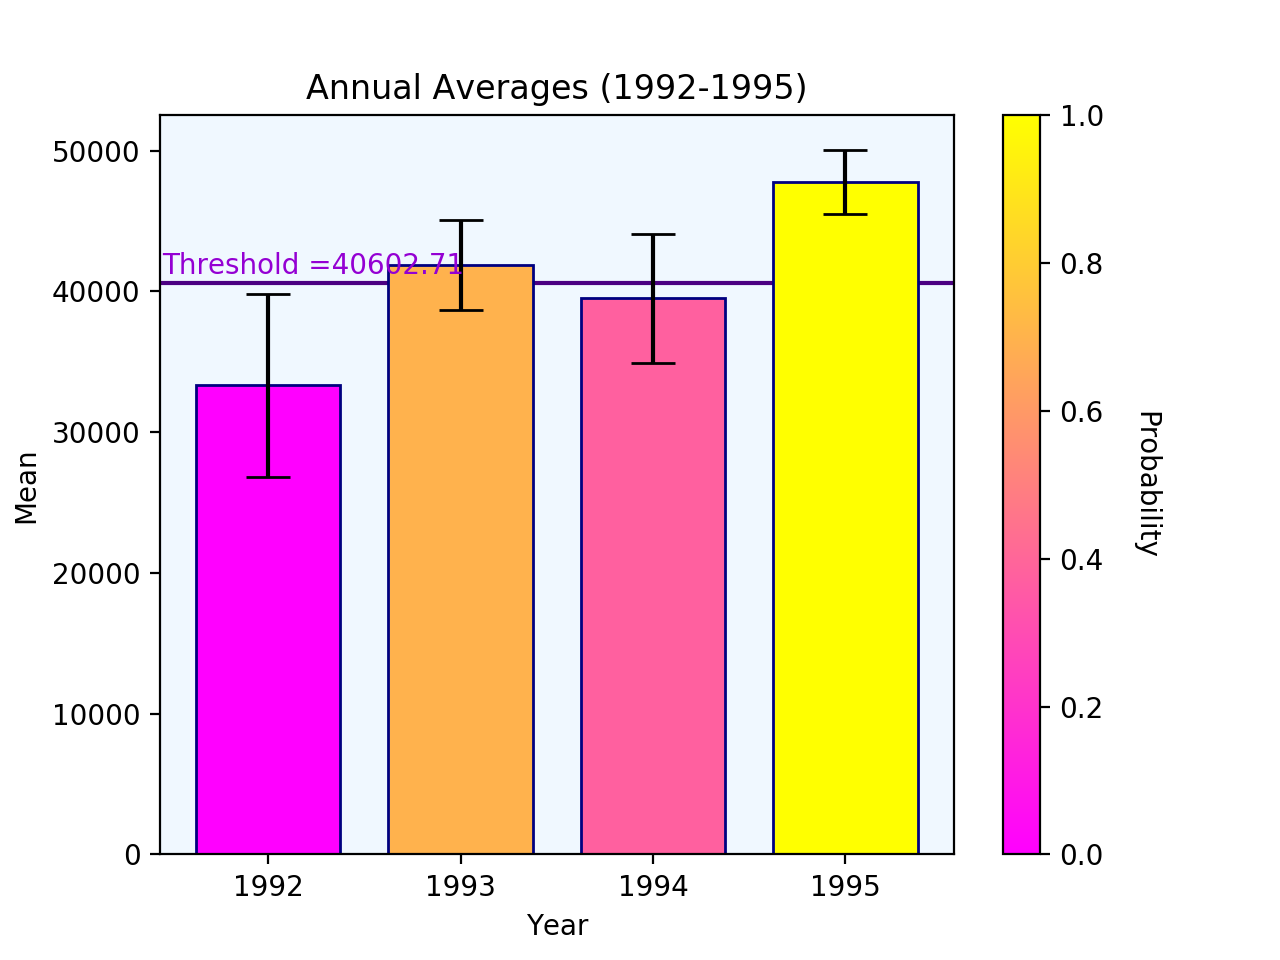

In [8]:
fig, ax = plt.subplots()

# Bar chart attributes
width = 0.75
z = st.norm.ppf(0.975)


# Data cleaning
df = df.rename(columns={1992: '1992', 1993:'1993', 1994: '1994', 1995: '1995'})

# Obtain group and total mean, standard error, and 95% confidence interval per year
mean = df.mean(axis=1)
y = df.mean().mean()
error = df.std(axis=1) / np.sqrt(df.shape[1])

# Use z-score of 1.96 to obtain margin of error for 95% confidence interval. 
# Make each color follow this gradient
margin = z*error
normal = Normalize(vmin=-z, vmax=z)
gradient = normal((mean - y) / error)


# Add color gradient to each bar using a color scheme
scheme = 'spring'
colormap = cm.get_cmap(scheme)
colors = [colormap(x) for x in gradient]
    
# Color bar
colored = cm.ScalarMappable(cmap=colormap, norm=plt.Normalize(0, 1))
colored.set_array([])
cbar = plt.colorbar(colored)
cbar.set_label('Probability', rotation=270, labelpad=20)


# Plot 
chart = plt.bar(df.index, mean, width, yerr=margin, capsize=8, color=colors, 
                edgecolor='navy', align='center')
ax.set_facecolor('aliceblue')
ax.set(xlabel='Year', ylabel='Mean', title='Annual Averages (1992-1995)')

# Add a threshold initially set to the total mean
line = plt.axhline(y, zorder=0, color='indigo')
text = ax.text(1991.45, y + 600, 'Threshold =' + str(round(y, 2)), color='darkviolet')

# Change x-axis to years
plt.xticks(df.index);

In [9]:
def update(event):
    for i in range(df.shape[0]):
        
        # Normalize using the previously defined 'normal' class object
        current = event.ydata
        refill = colormap(normal((mean.values[i] - current) / error.values[i]))
        
        #Update fill and edgecolor of each bar
        chart[i].set_color(refill)
        chart[i].set_edgecolor('navy')
        
        # Update position of confidence interval lines
        line.set_ydata(current)
        text.set_text("Threshold = " + str(round(current, 2)))
        text.set_position((1991.45, current + 600))  

# Final interactive figure
figure = plt.gcf().canvas.mpl_connect('button_release_event', update);